Episode 1: Total Reward = 12.0, Epsilon = 0.998
Episode 2: Total Reward = 10.0, Epsilon = 0.996
Episode 3: Total Reward = 48.0, Epsilon = 0.994
Episode 4: Total Reward = 10.0, Epsilon = 0.992
Episode 5: Total Reward = 19.0, Epsilon = 0.990
Episode 6: Total Reward = 40.0, Epsilon = 0.988
Episode 7: Total Reward = 15.0, Epsilon = 0.986
Episode 8: Total Reward = 24.0, Epsilon = 0.984
Episode 9: Total Reward = 18.0, Epsilon = 0.982
Episode 10: Total Reward = 15.0, Epsilon = 0.980
Episode 11: Total Reward = 18.0, Epsilon = 0.978
Episode 12: Total Reward = 10.0, Epsilon = 0.976
Episode 13: Total Reward = 29.0, Epsilon = 0.974
Episode 14: Total Reward = 20.0, Epsilon = 0.972
Episode 15: Total Reward = 17.0, Epsilon = 0.970
Episode 16: Total Reward = 46.0, Epsilon = 0.968
Episode 17: Total Reward = 17.0, Epsilon = 0.967
Episode 18: Total Reward = 16.0, Epsilon = 0.965
Episode 19: Total Reward = 59.0, Epsilon = 0.963
Episode 20: Total Reward = 18.0, Epsilon = 0.961
Episode 21: Total Reward = 11

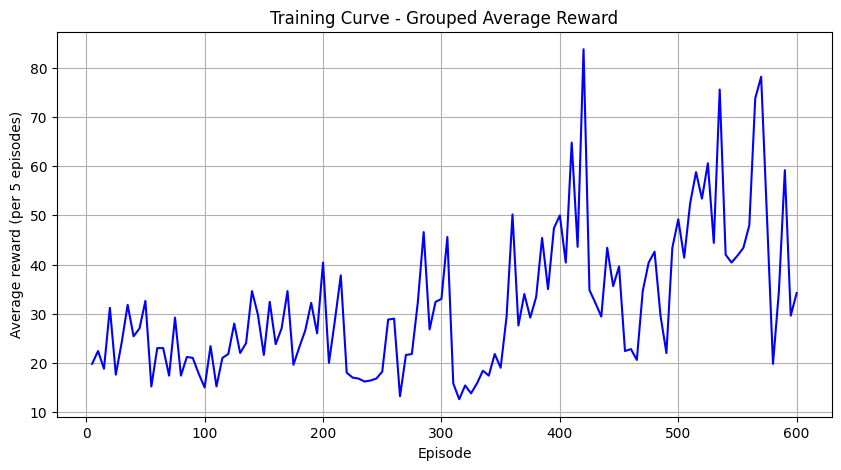

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import gym
import matplotlib.pyplot as plt
np.bool8 = np.bool_

# hyperparameters
alpha = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.998
episodes = 600
n_step = 3 # n-step SARSA

env = gym.make("CartPole-v1")
state_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

# define Q-network
def Q_network():
    model = keras.Sequential([
        keras.layers.Dense(32, activation="relu", input_shape=(state_space_size,)),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(action_space_size, activation="linear")
    ])
    model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=alpha))
    return model

model = Q_network()

def select_action(state):
    if np.random.rand() < epsilon:
        return np.random.choice(action_space_size)
    else:
        Q_values = model.predict(state, verbose=0)
        return np.argmax(Q_values[0])

def train_model():
    global epsilon
    rewards_per_episode, group_rewards, group_size = [], [], 5

    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_space_size])
        action = select_action(state)
        total_reward = 0
        done = False

        # initialize n-step buffer
        states, actions, rewards = [], [], []
        states.append(state)
        actions.append(action)

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_space_size])
            next_action = select_action(next_state)

            # store experience
            states.append(next_state)
            actions.append(next_action)
            rewards.append(reward)

            # update if enough steps or episode ends
            if len(rewards) >= n_step or done:
                # compute n-step return
                if done:
                    G = 0
                else:
                    G = model.predict(next_state, verbose=0)[0][next_action]

                # backward sum rewards
                for t in reversed(range(len(rewards))):
                    G = rewards[t] + gamma * G

                # update Q(s_t, a_t) using semi-gradient
                Q_values = model.predict(states[0], verbose=0)
                Q_values[0][actions[0]] = G  # direct assignment (semi-gradient)
                model.train_on_batch(states[0], Q_values)

                # remove oldest experience
                states.pop(0)
                actions.pop(0)
                rewards.pop(0)

            state, action = next_state, next_action
            total_reward += reward

        # epsilon decay
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        rewards_per_episode.append(total_reward)
        if (episode + 1) % group_size == 0:
            start_idx = max(0, episode+1-group_size)
            avg_reward = np.mean(rewards_per_episode[start_idx:episode+1])
            group_rewards.append(avg_reward)
        print(f"Episode {episode+1}: Total Reward = {total_reward}, Epsilon = {epsilon:.3f}")

        if total_reward > 200:
            break

    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(group_rewards)) * group_size + group_size, group_rewards, 'b')
    plt.xlabel('Episode')
    plt.ylabel('Average reward (per 5 episodes)')
    plt.title('Training Curve - Grouped Average Reward')
    plt.grid(True)
    plt.show()

train_model()

As shown above, I modified the code from Exercise IV to implement n-step SARSA with a neural network as the function approximator.
For the reference, I chose the episodic semi-gradient SARSA for estimating q^≈q*.
As cart-pole is a simple problem, I used the same 3-layer neural network.
From the training process, we can tell that large epsilon brings unstable rewards but more exploration.
I tried to tune the hyperparameters, especially epsilon_decay.
By plotting the average return of every 5 epochs, we can see that when epsilon decreases, larger rewards appear more often, and the trend is rising.
That indicates the model is learning useful action values.
As the training time is quite long (about 1 min for 10 epochs), I chose to break (when total reward reaches 200 or) after 600 episodes.